In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import clustering as cl
import warnings
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


## Load Pickel file from archetype_analysis.ipynb

In [2]:
df_teams_aa = pd.read_pickle("./pickle_files/df_teams_only_aa.pkl")

In [3]:
df_teams_aa.iloc[:,:-1] = (df_teams_aa.iloc[:,:-1] * 100 ).round(0).astype(int)

## Load match related data

In [4]:
df_matches_19_20 = pd.read_csv("germany_match_stats/germany-bundesliga-matches-2019-to-2020-stats.csv")
df_matches_18_19 = pd.read_csv("germany_match_stats/germany-bundesliga-matches-2018-to-2019-stats.csv")
df_matches_17_18 = pd.read_csv("germany_match_stats/germany-bundesliga-matches-2017-to-2018-stats.csv")
df_matches_16_17 = pd.read_csv("germany_match_stats/germany-bundesliga-matches-2016-to-2017-stats.csv")
df_matches_15_16 = pd.read_csv("germany_match_stats/germany-bundesliga-matches-2015-to-2016-stats.csv")

In [5]:
df_all = pd.concat([df_matches_19_20, 
                    df_matches_18_19, 
                    df_matches_17_18, 
                    df_matches_16_17, 
                    df_matches_15_16],sort=False)
df_all = df_all[df_all['status'] != 'suspended']

In [6]:
df_all.sort_values('timestamp', inplace=True)
df_all.reset_index(inplace=True)
df_all.drop('index', axis=1, inplace=True)

In [7]:
df_all.to_excel('test.xlsx')

In [8]:
df_all[df_all['status']=='complete'].tail()

,timestamp,date_GMT,status,attendance,home_team_name,away_team_name,referee,Pre-Match PPG (Home),Pre-Match PPG (Away),home_ppg,...,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,stadium_name
1507,1592411400,Jun 17 2020 - 4:30pm,complete,NaN,Eintracht Frankfurt,Schalke 04,Guido Winkmann,1.47,1.13,1.56,...,1.65,4.20,5.35,1.23,1.74,2.90,5.35,1.74,1.95,Commerzbank-Arena (Frankfurt am Main)
1508,1592418600,Jun 17 2020 - 6:30pm,complete,NaN,Augsburg,Hoffenheim,Deniz Aytekin,1.33,1.60,1.25,...,3.00,3.90,2.25,1.14,1.49,2.20,3.75,1.43,2.60,WWK Arena (Augsburg)
1509,1592418600,Jun 17 2020 - 6:30pm,complete,NaN,Bayer Leverkusen,Köln,Sven Jablonski,1.67,0.93,1.75,...,1.56,4.75,5.60,1.12,1.42,2.05,3.40,1.49,2.40,BayArena (Leverkusen)
1510,1592418600,Jun 17 2020 - 6:30pm,complete,NaN,RB Leipzig,Fortuna Düsseldorf,Manuel Gräfe,1.87,0.73,1.81,...,1.30,6.00,10.50,1.12,1.43,2.10,3.45,1.71,1.95,Red Bull Arena (Leipzig)
1511,1592418600,Jun 17 2020 - 6:30pm,complete,NaN,Borussia Dortmund,Mainz 05,Frank Willenborg,2.40,1.13,2.25,...,1.33,5.80,9.25,1.12,1.43,2.10,3.45,1.67,2.05,Signal-Iduna-Park (Dortmund)


In [9]:
df_all['attendance'][df_all['attendance'] < 0] = 0

In [10]:
from pandas.plotting import scatter_matrix

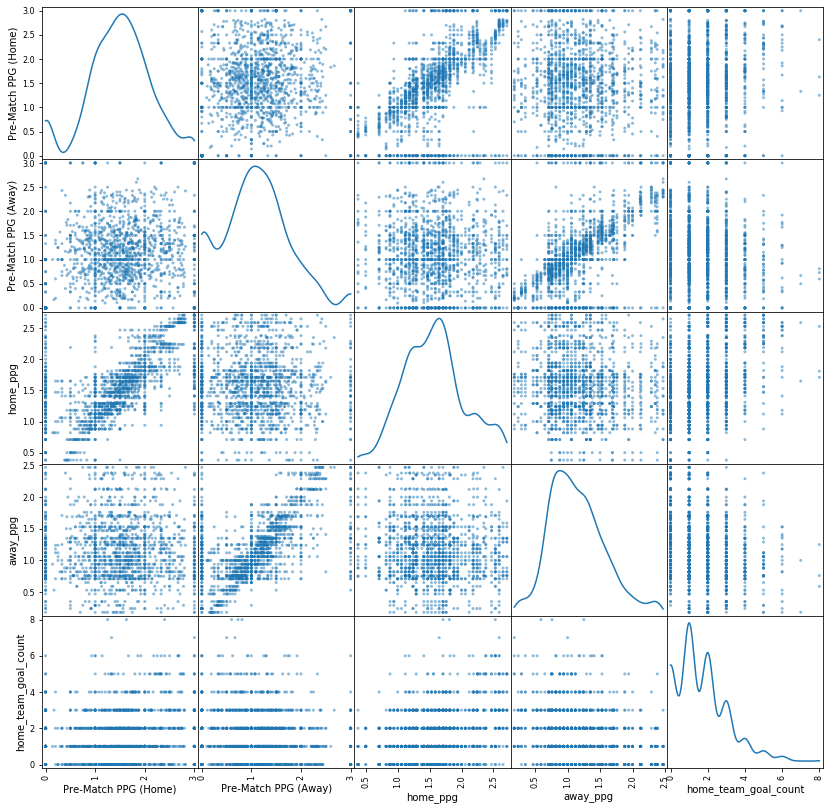

In [11]:
scatter_matrix(df_all[df_all.iloc[:,6:12].columns], diagonal='kde', figsize=(14,14));

## Append results from AA Analysis as features for home and away Team to match-related-dataset

In [12]:
# + 9 per match day
int_for_test = 1521
int_for_prediction = int_for_test - 9

In [13]:
columns=pd.Series(df_teams_aa.iloc[:,:-1].columns)
columns_h = list(columns.apply(lambda x: "ht_" + x))
columns_a = list(columns.apply(lambda x: "awt_" + x))

In [14]:
df_empty_columns = pd.DataFrame(columns=(columns_h + columns_a))
df_matches_with_aa = pd.concat([df_all,df_empty_columns], axis=1)

In [15]:
df_matches_with_aa_complete = df_matches_with_aa.copy()
df_matches_with_aa_complete = df_matches_with_aa_complete.iloc[:int_for_test,:]

In [16]:
#df_matches_with_aa_complete.to_excel('test.xlsx')

In [17]:
pre_cols = [col for col in df_matches_with_aa_complete.columns if 'pre' in col]
PRE_cols = [col for col in df_matches_with_aa_complete.columns if 'Pre' in col]
aa_cols_home = [col for col in df_matches_with_aa_complete.columns if 'ht_' in col]
aa_cols_away = [col for col in df_matches_with_aa_complete.columns if 'awt_' in col]

In [18]:
for index, row in df_matches_with_aa_complete.iterrows():
    teams_aa_score_home = list(df_teams_aa[df_teams_aa['common_name']==row['home_team_name']].iloc[:,:-1].iloc[0])
    teams_aa_score_away = list(df_teams_aa[df_teams_aa['common_name']==row['away_team_name']].iloc[:,:-1].iloc[0])
    
    df_matches_with_aa_complete.at[index, aa_cols_home] = teams_aa_score_home
    df_matches_with_aa_complete.at[index, aa_cols_away] = teams_aa_score_away 

In [19]:
df_matches_with_aa_complete['HTGDIFF'] = df_matches_with_aa_complete['home_team_goal_count'] - df_matches_with_aa_complete['away_team_goal_count']
df_matches_with_aa_complete['ATGDIFF'] = df_matches_with_aa_complete['away_team_goal_count'] - df_matches_with_aa_complete['home_team_goal_count']

## Calculate AVG goal difference for home and away team rolling 10 Games

In [20]:
def avg_goal_diff(df, avg_h_a_diff, a_h_team, a_h_goal_letter):
    """
    input: 
        df = dataframe with all results
        avg_h_a_diff = name of the new column
        a_h_team = HomeTeam or AwayTeam
        a_h_goal_letter = 'H' for home or 'A' for away
    output: 
        avg_per_team = dictionary with with team as key and columns as values with new column H/ATGDIFF
    """
    df[avg_h_a_diff] = 0
    avg_per_team = {}
    all_teams = df[a_h_team].unique()
    for t in all_teams:
        df_team = df[df[a_h_team]==t].fillna(0)
        result = df_team['{}TGDIFF'.format(a_h_goal_letter)].rolling(4).mean()
        df_team[avg_h_a_diff] = result
        avg_per_team[t] = df_team
    return avg_per_team

In [21]:
d_AVGFTHG = avg_goal_diff(df_matches_with_aa_complete, 'AVGHTGDIFF', 'home_team_name', 'H')

In [22]:
def from_dict_value_to_df(d):
    """
    input = dictionary 
    output = dataframe as part of all the values from the dictionary
    """
    df = pd.DataFrame()
    for v in d.values():
        df = df.append(v)
    return df

In [23]:
df_AVGFTHG = from_dict_value_to_df(d_AVGFTHG)
df_AVGFTHG.sort_index(inplace=True)

In [24]:
d_AVGFTAG = avg_goal_diff(df_AVGFTHG, 'AVGATGDIFF', 'away_team_name', 'A')
df_all = from_dict_value_to_df(d_AVGFTAG)
df_all.sort_index(inplace=True)
df_all['AVGATGDIFF'].fillna(0, inplace=True)

## Add per match game results from last three games

In [25]:
df_all['goal_diff'] = df_all['home_team_goal_count'] - df_all['away_team_goal_count']

for index, row in df_all[df_all['status']=='complete'].iterrows():
    if df_all['goal_diff'][index] > 0:
        df_all.at[index,'result'] = 3
    elif df_all['goal_diff'][index] == 0:
        df_all.at[index,'result'] = 2
    else:
        df_all.at[index,'result'] = 1

In [26]:
def previous_data(df, h_or_a_team, column, letter, past_n):
    """
    input: 
        df = dataframe with all results
        a_h_team = HomeTeam or AwayTeam
        column = column selected to get previous data from
    output:
        team_with_past_dict = dictionary with team as a key and columns as values with new 
                              columns with past value
    """
    d = dict()
    team_with_past_dict = dict()
    all_teams = df[h_or_a_team].unique()
    for team in all_teams:
        n_games = len(df[df[h_or_a_team]==team])
        team_with_past_dict[team] = df[df[h_or_a_team]==team]
        for i in range(1, past_n):
            d[i] = team_with_past_dict[team].assign(
                result=team_with_past_dict[team].groupby(h_or_a_team)[column].shift(i)
            ).fillna({'{}_X'.format(column): 0})
            team_with_past_dict[team]['{}_{}_{}'.format(letter, column, i)] = d[i].result
    return team_with_past_dict

In [27]:
def previous_data_call(df, side, column, letter, iterations):
    d = previous_data(df, side, column, letter, iterations)
    df_result= from_dict_value_to_df(d)
    df_result.sort_index(inplace=True)
    return df_result

In [28]:
df_last_home_results = previous_data_call(df_all, 'home_team_name', 'result', 'H', 3)
df_last_away_results = previous_data_call(df_last_home_results, 'away_team_name', 'result', 'A', 3)

In [29]:
df_last_last_HTGDIFF_results = previous_data_call(df_last_away_results, 'home_team_name', 'HTGDIFF', 'H', 3)
df_last_last_ATGDIFF_results = previous_data_call(df_last_last_HTGDIFF_results, 'away_team_name', 'ATGDIFF', 'A', 3)

In [30]:
df_last_AVGFTHG_results = previous_data_call(df_last_last_ATGDIFF_results, 'home_team_name', 'AVGHTGDIFF', 'H', 2)
df_last_AVGFTAG_results = previous_data_call(df_last_AVGFTHG_results, 'away_team_name', 'AVGATGDIFF', 'A', 2)

In [31]:
df_all = df_last_AVGFTAG_results.copy()

In [32]:
df_all.shape

(1521, 85)

In [33]:
df_matches_with_aa_numeric = df_all._get_numeric_data()
df_matches_with_aa_numeric.drop(['timestamp', 'goal_diff', 'result', 'home_team_goal_count', 'away_team_goal_count'], axis=1, inplace=True)
df_matches_with_aa_numeric.isnull().sum(axis = 0)

attendance               0
Pre-Match PPG (Home)     0
Pre-Match PPG (Away)     0
home_ppg                 0
away_ppg                 0
                        ..
H_HTGDIFF_2             48
A_ATGDIFF_1             24
A_ATGDIFF_2             48
H_AVGHTGDIFF_1          24
A_AVGATGDIFF_1          24
Length: 72, dtype: int64

In [34]:
df_norm = (df_matches_with_aa_numeric - df_matches_with_aa_numeric.min()) / (df_matches_with_aa_numeric.max() - df_matches_with_aa_numeric.min())

In [35]:
df_next_games = df_norm.iloc[int_for_prediction:,:]
a = df_next_games.loc[:, (df_next_games != 0).any(axis=0)]
a.dropna(axis=1,inplace=True)
a.drop(['HTGDIFF', 'ATGDIFF'], inplace=True, axis=1)

In [36]:
df_next_games_teams = df_matches_with_aa_complete.iloc[int_for_prediction:,:][['home_team_name', 'away_team_name']]

In [37]:
df_next_games_teams

,home_team_name,away_team_name
1512,Bayern München,Freiburg
1513,RB Leipzig,Borussia Dortmund
1514,Hoffenheim,Union Berlin
1515,Fortuna Düsseldorf,Augsburg
1516,Hertha BSC,Bayer Leverkusen
1517,Mainz 05,Werder Bremen
1518,Schalke 04,Wolfsburg
1519,Köln,Eintracht Frankfurt
1520,Paderborn,Borussia M'gladbach


In [38]:
predictable_columns = [
       'Pre-Match PPG (Home)', 'Pre-Match PPG (Away)', 'attendance', 'home_ppg', 'away_ppg',
       'average_goals_per_match_pre_match', 'btts_percentage_pre_match',
       'over_15_percentage_pre_match', 'over_25_percentage_pre_match',
       'over_35_percentage_pre_match', 'over_45_percentage_pre_match',
       'over_15_HT_FHG_percentage_pre_match',
       'over_05_HT_FHG_percentage_pre_match',
       'average_corners_per_match_pre_match',
       'average_cards_per_match_pre_match', 'odds_ft_home_team_win',
       'odds_ft_draw', 'odds_ft_away_team_win', 'odds_ft_over15',
       'odds_ft_over25', 'odds_ft_over35', 'odds_ft_over45', 'odds_btts_yes',
       'odds_btts_no', 'ht_0', 'ht_1', 'ht_2', 'ht_3', 'ht_4', 'awt_0',
       'awt_1', 'awt_2', 'awt_3', 'awt_4', 'AVGHTGDIFF', 'AVGATGDIFF', 'H_result_1',
       'H_result_2', 'A_result_1', 'A_result_2', 'H_HTGDIFF_1', 'H_HTGDIFF_2',
       'A_ATGDIFF_1', 'A_ATGDIFF_2', 'H_AVGHTGDIFF_1', 'A_AVGATGDIFF_1'
]

In [39]:
df_X = df_norm[predictable_columns]
#df_X.isnull().sum(axis = 0)

In [40]:
df_X.fillna(0,inplace=True)

In [41]:
X = df_X.iloc[:int_for_prediction,:]
Y = df_all.iloc[:int_for_prediction,:]['result']
Z = df_X.iloc[int_for_prediction:,:]

In [42]:
X = X.iloc[17:,:]

In [43]:
Y = Y[17:]

In [44]:
X.to_pickle("pickle_files/X.pkl")
Y.to_pickle("pickle_files/Y.pkl")
Z.to_pickle("pickle_files/Z.pkl")
df_next_games_teams.to_pickle("pickle_files/next_games.pkl")